<a href="https://colab.research.google.com/github/ktaniguc/RNNSongGenerator/blob/main/LstmSongGen_wDataAug_pytorch_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 注意点
- 意味不明なこと言っている&間違った言葉の使い方をしている可能性大

### 要改善点(反省点)
- dataaugmentation の前に
  - dropout など、過学習防止の策を取る
  - keras のCuDNNでは拡張性に乏しい(dropoutの実装がないなど)→pytorchに乗り換える
 - LSTM とは言えども、それほど長いメロディーは覚えられないのでは
  - batch でもっと細かく切ってみる?一旦曲ごとに分ける
  - http://mitaka.boo.jp/articles/article12
- data augmentation を行うに当たり(移調+1~+11)、大量のリソースが必要
  - pytorch にすればバッチ処理可能？
- 参考
  - [LSTMによる自動作曲システムの構築] file:///Users/taniguchikouhei/OneDrive/downloads/48146440-1.pdf
  - [PyTorchを使ってLSTMモデルを実装する―RNNで文章生成〈８〉]http://mitaka.boo.jp/articles/article11
  - [PyTorchを使ってLSTMで文章分類を実装してみた]https://qiita.com/m__k/items/841950a57a0d7ff05506
  - [PyTorchのRNNクラスを使って文章を生成してみよう]https://atmarkit.itmedia.co.jp/ait/articles/2103/26/news026.html
  - [【Pytorch入門】ニュース記事で文章生成がしたい]https://qiita.com/hcpmiyuki/items/c6afc037518542cfe410

### 改善した点
- embedding 層、batch 処理、bptt(学習の文章長を制限) の導入
- 移調のdata augmentation を行えるように
- dropout層追加
- 20epoch ごとにmodel 保存、midi 生成ができるように(更新アリ)

### 更新
- 08/24
  - 何故かBATCH_SIZE が2以上ではうまく行かない
    - 修正完了(しんどい...)
  - 音楽生成の部分は他のipynb に任せる
- 8/25
  - 検証データをちゃんと設け、perplexity で精度を評価できるように
    - どのepoch のモデルが良いかを見るため。
  - train, validation 用に自動でデータを分割
    - defuault では0.95:0.05 (どーせ検証といえど聴かんとわからんから申し訳程度に)
  - bug (needless option(remove batch_first=True))直した
  - 20epoch ごとにモデルの保存ではなく、validation data を用いたperplexity の値が改善されたときに保存するように変更

## setup

In [39]:
#!pip install tqdm
!pip install mido keras torch
#!pip install -U torchtext

In [40]:
from google.colab import drive
drive.mount('/content/drive/')
!cd "/content/drive/MyDrive/"
!ls /content/drive/MyDrive/Colab_Notebooks/songs/test

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
akaimahura-rei.MID  sky.MID	   syoujyonomamade.MID	 tukito_piano_010.MID
koneko-runa.MID     summer-va.MID  tukito_piano_005.MID


In [42]:
#IN/OUT/出力結果/ハイパーパラメータの名前を設定
TRAIN_DIR="/content/drive/MyDrive/Colab_Notebooks/songs/train/" #学習用midi データ置き場(評価用はないっす)
BPM="150"
augment=12 #data augumentation でnote をどこまで移調するか。+1で半音。
argstep=1 #移調のstep
DIR = "/content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/" #モデルやら生成物やらの出力先
if os.path.exists(DIR):
  !mkdir -p {DIR + "train_txt/"} #学習用データ midi をtext に変換したものを保管
  !mkdir -p {DIR + "result_txt/"} #予測した結果をtxt で保管
  !mkdir -p {DIR + "result_mid/"} #予測結果txt をmidi に変換して保管
  !mkdir -p {DIR + "output_model/"}
  TRAIN_TXT_DIR = DIR + "train_txt/" #学習用データ midi をtext に変換したものを保管
  RESULT_TXT_DIR = DIR + "result_txt/" #予測した結果をtxt で保管
  RESULT_MIDI_DIR = DIR + "result_mid/" #予測結果txt をmidi に変換して保管
  OUTPUT_MODEL_DIR = DIR + "output_model/"
else:
  print("please make directory for saving files first.")

BATCH_SIZE=20 #ミニバッチサイズ
BPTT_LEN = 140 #text とtarget の長さ 700(BPM=120)で30秒くらい。
EMBEDDING_DIM = 512 #embedding 層
HIDDEN_DIM = 512 #隠れ層
DROPOUT = 0.5
max_norm = 0.25 #勾配クリッピング
epochs = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## main

In [41]:
#https://qiita.com/ysit/items/a601cb59523cc1961556
#鬼のimport祭り
import mido
from mido import Message, MidiFile
from pathlib import Path
import sys, os
import random
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from tensorflow import keras
import numpy as np
import mido
from mido import Message, MidiFile, MidiTrack, MetaMessage
import sys
import matplotlib.pyplot as plt
import math

1.9.0+cu102 True


In [43]:
#cuda であーだこーだ怒られたときの対処セル。いらないかも。
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!ls -d /usr/local/cuda-*
!which nvcc
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.0/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.0/lib64:{ld}"
!nvcc --version
##!pip install torch==1.8.0
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#assert torch.__version__.startswith("1.8")

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
1.9.0+cu102
/usr/local/cuda-10.0  /usr/local/cuda-10.1  /usr/local/cuda-11.0
/usr/local/cuda/bin/nvcc
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


mid2txt.py

In [44]:
# 各トラック毎の全メッセージを表示する
def dump_track(track_obj):
    for msg in track_obj:
        print(msg)

# 全トラックの全メッセージをトラック毎に表示する
def dump_smf(midi_obj):
    for i, track in enumerate(midi_obj.tracks):
        print(f"Track {i}: {track.name}")
        dump_track(track)

def note_on_off(msg_type):
  if msg_type == "note_on":
    return "1_"
  else:
    return "0_"

pathlist = Path(TRAIN_DIR).glob('**/*.[mM][iI][dD]')
outputDir = TRAIN_TXT_DIR
for path in pathlist:
  filename = os.path.split(path)[1].replace(".mid", "")
  for i_scale in range(0, augment, argstep):
    print("transpositon: +", i_scale)
    outputfile_wDir = TRAIN_TXT_DIR + filename + "_plus" + str(i_scale) + ".txt"
    print("output text file name : ", outputfile_wDir)
    f = open(outputfile_wDir, 'w')
    mid = MidiFile(path)
    #dump_smf(mid)
    for i, track in enumerate(mid.tracks):
      for msg in track:
        chunk = ""
        if msg.type == "note_on" or msg.type == "note_off":
          #chunk = note_on_off(msg.type)
          chunk = "1_" + str(msg.note+i_scale) + "_"
          #note がoff == note がon かつvelocity 0なのでvelocity のみで調整
          if msg.type == "note_off":
            chunk += "0_"
          else:
            chunk += str(msg.velocity) + "_"
          chunk += str(msg.time) + ","
          f.write(chunk)
    f.close()

transpositon: + 0
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/train_txt/MAROON 5_Misery_plus0.txt
transpositon: + 1
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/train_txt/MAROON 5_Misery_plus1.txt
transpositon: + 2
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/train_txt/MAROON 5_Misery_plus2.txt
transpositon: + 3
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/train_txt/MAROON 5_Misery_plus3.txt
transpositon: + 4
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/train_txt/MAROON 5_Misery_plus4.txt
transpositon: + 5
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/train_txt/MAROON 5_Misery_plus5.txt
transpositon: + 6
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/train_txt/MAROON 5_Misery_plus6.txt
transpositon:

main.py

In [45]:
#辞書を持っておくオブジェクト
class EncoderDecoder(object):
    def __init__(self):
        # word_to_idの辞書
        self.w2i = {}
        # id_to_wordの辞書
        self.i2w = {}

    # コールされる関数
    def __call__(self, sentence, maxlength=4000):
        return self.transform(sentence, maxlength)

    # 辞書作成
    def make_dict(self, sentences):
      for sentence in sentences:
        if sentence not in self.w2i:
          new_id = len(self.w2i)
          self.w2i[sentence] = new_id
          self.i2w[new_id] = sentence

    # 読み込んだデータをまとめてidに変換する
    def transform(self, sentences, maxlength=4000):
        output = []
        for sentence in sentences:
            idx = self.w2i[sentence]
            output.append(idx)
        return output

    # １文ずつ単語リストに直す
    def decode(self, sentence):
        return [self.i2w[id] for id in sentence if id != 0]

In [46]:
#データの読み込み、準備
#print(torch.__version__)
#chunk の辞書化

class MyDataset(object):
  """データを(時系列長, バッチサイズ)の形状で返す"""

  def __init__(self, data, batch_size, bptt_len):
    nbatch = data.size(0) // batch_size
    data = data.narrow(0, 0, nbatch * batch_size)
    self.data = data.view(batch_size, -1).t().contiguous()
    self.batch_size = batch_size
    self.bptt_len = bptt_len
  @classmethod
  def splits(cls, datasets, batch_size, bptt_len):
    ret = []
    for data in datasets:
      ret.append(cls(data, batch_size, bptt_len))
    return tuple(ret)

  def __len__(self):
    return math.ceil((len(self.data) - 1 ) / self.bptt_len)
  
  def __iter__(self):
    for i in range(0, len(self.data) - 1, self.bptt_len):
      seq_len = min(self.bptt_len, len(self.data) - 1 - i)
      text = self.data[i:i + seq_len]
      target = self.data[i + 1:i + 1 + seq_len]
      yield text, target

#データの準備
inputTextList = Path(DIR+"train_txt").glob('**/*.txt')
mididata = []
maxlength = 0
for inputText in inputTextList:
  f = open(inputText, 'r')
  texts = f.read()
  text = texts.split(",")
  text.pop(-1)
  mididata = mididata + text
  if len(mididata) > maxlength:
    maxlength = len(text)
#二次元配列[曲][ノート]にする
encTool = EncoderDecoder()
encTool.make_dict(mididata)
data_id = encTool(mididata, maxlength=maxlength)
data_size = len(data_id)
train_ratio = 0.95
val_ratio = 0.05
train_size = math.floor(data_size * train_ratio)
val_size = math.floor(data_size * val_ratio)
train = torch.tensor(data_id[:train_size], dtype=torch.long, device=device)
val = torch.tensor(data_id[train_size:train_size + val_size],
                   dtype=torch.long, device=device)
dummy_b = []
test = torch.tensor(dummy_b,
                    dtype=torch.long, device=device)
train_iter, val_iter, test_iter = MyDataset.splits(
    (train, val, test), BATCH_SIZE, BPTT_LEN)
print(len(train), len(val), len(test))

203604 10716 0


In [47]:
#ネットの定義
class RNNLM(nn.Module):
    def __init__(self, vocab_size, emb_dim, h_dim, dropout):
        '''
        vocab_size:語彙の数
        emb_dim:埋め込みベクトルの次元
        h_dim:隠れ層の次元
        dropout: ドロップアウトの確率
        '''
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.drop1 = nn.Dropout(dropout)
        self.lstm1 = nn.LSTM(emb_dim, h_dim)
        self.drop2 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(h_dim, emb_dim)
        self.drop3 = nn.Dropout(dropout)
        self.linear = nn.Linear(emb_dim, vocab_size)

        # 重みを初期化
        #他にも色々方法はある https://pytorch.org/docs/stable/nn.init.html
        nn.init.normal_(self.embed.weight, std=0.01)
        nn.init.normal_(self.lstm1.weight_ih_l0, std=1/math.sqrt(emb_dim))
        nn.init.normal_(self.lstm1.weight_hh_l0, std=1/math.sqrt(h_dim))
        nn.init.zeros_(self.lstm1.bias_ih_l0)
        nn.init.zeros_(self.lstm1.bias_hh_l0)
        nn.init.normal_(self.lstm2.weight_ih_l0, std=1/math.sqrt(emb_dim))
        nn.init.normal_(self.lstm2.weight_hh_l0, std=1/math.sqrt(h_dim))
        nn.init.zeros_(self.lstm2.bias_ih_l0)
        nn.init.zeros_(self.lstm2.bias_hh_l0)
        self.linear.weight = self.embed.weight  # 重み共有
        nn.init.zeros_(self.linear.bias)

    def forward(self, sentence, hidden1_prev, hidden2_prev):
        emb = self.embed(sentence)
        emb = self.drop1(emb)
        lstm1_out, hidden1_next = self.lstm1(emb, hidden1_prev)
        lstm1_out = self.drop2(lstm1_out)
        lstm2_out, hidden2_next = self.lstm2(lstm1_out, hidden2_prev)
        lstm2_out = self.drop3(lstm2_out)
        out = self.linear(lstm2_out)
        #hidden_next:隠れ状態と記憶セルのセル状態を含んだタプル
        return out, hidden1_next, hidden2_next

Build model...


  0%|          | 1/300 [00:04<21:47,  4.37s/it]

Saving the checkpoint...
| epoch 1 : valid perplexity 4088.57 |


  1%|          | 2/300 [00:08<21:24,  4.31s/it]

| epoch 2 : valid perplexity 3996.29 |


  1%|          | 3/300 [00:12<21:14,  4.29s/it]

| epoch 3 : valid perplexity 2904.29 |


  1%|▏         | 4/300 [00:17<21:06,  4.28s/it]

| epoch 4 : valid perplexity 1991.83 |


  2%|▏         | 5/300 [00:21<21:01,  4.27s/it]

| epoch 5 : valid perplexity 1422.19 |


  2%|▏         | 6/300 [00:25<20:58,  4.28s/it]

| epoch 6 : valid perplexity 1127.07 |


  2%|▏         | 7/300 [00:29<20:52,  4.27s/it]

| epoch 7 : valid perplexity 948.81 |


  3%|▎         | 8/300 [00:34<20:46,  4.27s/it]

| epoch 8 : valid perplexity 861.91 |


  3%|▎         | 9/300 [00:38<20:43,  4.27s/it]

| epoch 9 : valid perplexity 759.65 |


  3%|▎         | 10/300 [00:42<20:38,  4.27s/it]

| epoch 10 : valid perplexity 754.74 |


  4%|▎         | 11/300 [00:47<20:33,  4.27s/it]

| epoch 11 : valid perplexity 659.70 |


  4%|▍         | 12/300 [00:51<20:29,  4.27s/it]

| epoch 12 : valid perplexity 623.74 |


  4%|▍         | 13/300 [00:55<20:27,  4.28s/it]

| epoch 13 : valid perplexity 542.66 |


  5%|▍         | 14/300 [00:59<20:21,  4.27s/it]

| epoch 14 : valid perplexity 494.98 |


  5%|▌         | 15/300 [01:04<20:17,  4.27s/it]

| epoch 15 : valid perplexity 458.06 |


  5%|▌         | 16/300 [01:08<20:13,  4.27s/it]

| epoch 16 : valid perplexity 389.92 |


  6%|▌         | 17/300 [01:12<20:08,  4.27s/it]

| epoch 17 : valid perplexity 369.39 |


  6%|▌         | 18/300 [01:16<20:04,  4.27s/it]

| epoch 18 : valid perplexity 361.54 |


  6%|▋         | 19/300 [01:21<19:59,  4.27s/it]

| epoch 19 : valid perplexity 313.82 |


  7%|▋         | 20/300 [01:25<19:56,  4.27s/it]

| epoch 20 : valid perplexity 326.54 |


  7%|▋         | 21/300 [01:29<19:59,  4.30s/it]

Saving the checkpoint...
| epoch 21 : valid perplexity 295.04 |


  7%|▋         | 22/300 [01:34<19:52,  4.29s/it]

| epoch 22 : valid perplexity 291.41 |


  8%|▊         | 23/300 [01:38<19:47,  4.29s/it]

| epoch 23 : valid perplexity 285.24 |


  8%|▊         | 24/300 [01:42<19:42,  4.28s/it]

| epoch 24 : valid perplexity 283.95 |


  8%|▊         | 25/300 [01:46<19:35,  4.28s/it]

| epoch 25 : valid perplexity 274.86 |


  9%|▊         | 26/300 [01:51<19:30,  4.27s/it]

| epoch 26 : valid perplexity 277.31 |


  9%|▉         | 27/300 [01:55<19:27,  4.28s/it]

| epoch 27 : valid perplexity 252.96 |


  9%|▉         | 28/300 [01:59<19:22,  4.27s/it]

| epoch 28 : valid perplexity 251.47 |


 10%|▉         | 29/300 [02:04<19:17,  4.27s/it]

| epoch 29 : valid perplexity 250.96 |


 10%|█         | 30/300 [02:08<19:14,  4.27s/it]

| epoch 30 : valid perplexity 251.69 |


 10%|█         | 31/300 [02:12<19:09,  4.27s/it]

| epoch 31 : valid perplexity 249.77 |


 11%|█         | 32/300 [02:16<19:04,  4.27s/it]

| epoch 32 : valid perplexity 251.10 |


 11%|█         | 33/300 [02:21<19:00,  4.27s/it]

| epoch 33 : valid perplexity 251.35 |


 11%|█▏        | 34/300 [02:25<18:57,  4.28s/it]

| epoch 34 : valid perplexity 251.42 |


 12%|█▏        | 35/300 [02:29<18:51,  4.27s/it]

| epoch 35 : valid perplexity 251.43 |


 12%|█▏        | 36/300 [02:33<18:46,  4.27s/it]

| epoch 36 : valid perplexity 251.44 |


 12%|█▏        | 37/300 [02:38<18:43,  4.27s/it]

| epoch 37 : valid perplexity 251.44 |


 13%|█▎        | 38/300 [02:42<18:39,  4.27s/it]

| epoch 38 : valid perplexity 251.44 |


 13%|█▎        | 39/300 [02:46<18:34,  4.27s/it]

| epoch 39 : valid perplexity 251.44 |


 13%|█▎        | 40/300 [02:51<18:30,  4.27s/it]

| epoch 40 : valid perplexity 251.44 |


 14%|█▎        | 41/300 [02:55<18:35,  4.31s/it]

Saving the checkpoint...
| epoch 41 : valid perplexity 251.44 |


 14%|█▍        | 42/300 [02:59<18:26,  4.29s/it]

| epoch 42 : valid perplexity 251.44 |


 14%|█▍        | 43/300 [03:03<18:20,  4.28s/it]

| epoch 43 : valid perplexity 251.44 |


 15%|█▍        | 44/300 [03:08<18:15,  4.28s/it]

| epoch 44 : valid perplexity 251.44 |


 15%|█▌        | 45/300 [03:12<18:10,  4.28s/it]

| epoch 45 : valid perplexity 251.44 |


 15%|█▌        | 46/300 [03:16<18:05,  4.27s/it]

| epoch 46 : valid perplexity 251.44 |


 16%|█▌        | 47/300 [03:21<18:00,  4.27s/it]

| epoch 47 : valid perplexity 251.44 |


 16%|█▌        | 48/300 [03:25<17:57,  4.28s/it]

| epoch 48 : valid perplexity 251.44 |


 16%|█▋        | 49/300 [03:29<17:51,  4.27s/it]

| epoch 49 : valid perplexity 251.44 |


 17%|█▋        | 50/300 [03:33<17:47,  4.27s/it]

| epoch 50 : valid perplexity 251.44 |


 17%|█▋        | 51/300 [03:38<17:43,  4.27s/it]

| epoch 51 : valid perplexity 251.44 |


 17%|█▋        | 52/300 [03:42<17:39,  4.27s/it]

| epoch 52 : valid perplexity 251.44 |


 18%|█▊        | 53/300 [03:46<17:34,  4.27s/it]

| epoch 53 : valid perplexity 251.44 |


 18%|█▊        | 54/300 [03:50<17:30,  4.27s/it]

| epoch 54 : valid perplexity 251.44 |


 18%|█▊        | 55/300 [03:55<17:27,  4.28s/it]

| epoch 55 : valid perplexity 251.44 |


 19%|█▊        | 56/300 [03:59<17:21,  4.27s/it]

| epoch 56 : valid perplexity 251.44 |


 19%|█▉        | 57/300 [04:03<17:16,  4.27s/it]

| epoch 57 : valid perplexity 251.44 |


 19%|█▉        | 58/300 [04:07<17:13,  4.27s/it]

| epoch 58 : valid perplexity 251.44 |


 20%|█▉        | 59/300 [04:12<17:09,  4.27s/it]

| epoch 59 : valid perplexity 251.44 |


 20%|██        | 60/300 [04:16<17:04,  4.27s/it]

| epoch 60 : valid perplexity 251.44 |


 20%|██        | 61/300 [04:20<17:07,  4.30s/it]

Saving the checkpoint...
| epoch 61 : valid perplexity 251.44 |


 21%|██        | 62/300 [04:25<17:02,  4.30s/it]

| epoch 62 : valid perplexity 251.44 |


 21%|██        | 63/300 [04:29<16:55,  4.28s/it]

| epoch 63 : valid perplexity 251.44 |


 21%|██▏       | 64/300 [04:33<16:49,  4.28s/it]

| epoch 64 : valid perplexity 251.44 |


 22%|██▏       | 65/300 [04:37<16:45,  4.28s/it]

| epoch 65 : valid perplexity 251.44 |


 22%|██▏       | 66/300 [04:42<16:40,  4.28s/it]

| epoch 66 : valid perplexity 251.44 |


 22%|██▏       | 67/300 [04:46<16:35,  4.27s/it]

| epoch 67 : valid perplexity 251.44 |


 23%|██▎       | 68/300 [04:50<16:30,  4.27s/it]

| epoch 68 : valid perplexity 251.44 |


 23%|██▎       | 69/300 [04:55<16:27,  4.28s/it]

| epoch 69 : valid perplexity 251.44 |


 23%|██▎       | 70/300 [04:59<16:22,  4.27s/it]

| epoch 70 : valid perplexity 251.44 |


 24%|██▎       | 71/300 [05:03<16:17,  4.27s/it]

| epoch 71 : valid perplexity 251.44 |


 24%|██▍       | 72/300 [05:07<16:13,  4.27s/it]

| epoch 72 : valid perplexity 251.44 |


 24%|██▍       | 73/300 [05:12<16:09,  4.27s/it]

| epoch 73 : valid perplexity 251.44 |


 25%|██▍       | 74/300 [05:16<16:04,  4.27s/it]

| epoch 74 : valid perplexity 251.44 |


 25%|██▌       | 75/300 [05:20<16:00,  4.27s/it]

| epoch 75 : valid perplexity 251.44 |


 25%|██▌       | 76/300 [05:24<15:57,  4.27s/it]

| epoch 76 : valid perplexity 251.44 |


 26%|██▌       | 77/300 [05:29<15:52,  4.27s/it]

| epoch 77 : valid perplexity 251.44 |


 26%|██▌       | 78/300 [05:33<15:47,  4.27s/it]

| epoch 78 : valid perplexity 251.44 |


 26%|██▋       | 79/300 [05:37<15:43,  4.27s/it]

| epoch 79 : valid perplexity 251.44 |


 27%|██▋       | 80/300 [05:42<15:39,  4.27s/it]

| epoch 80 : valid perplexity 251.44 |


 27%|██▋       | 81/300 [05:46<15:41,  4.30s/it]

Saving the checkpoint...
| epoch 81 : valid perplexity 251.44 |


 27%|██▋       | 82/300 [05:50<15:35,  4.29s/it]

| epoch 82 : valid perplexity 251.44 |


 28%|██▊       | 83/300 [05:54<15:30,  4.29s/it]

| epoch 83 : valid perplexity 251.44 |


 28%|██▊       | 84/300 [05:59<15:24,  4.28s/it]

| epoch 84 : valid perplexity 251.44 |


 28%|██▊       | 85/300 [06:03<15:19,  4.28s/it]

| epoch 85 : valid perplexity 251.44 |


 29%|██▊       | 86/300 [06:07<15:15,  4.28s/it]

| epoch 86 : valid perplexity 251.44 |


 29%|██▉       | 87/300 [06:12<15:10,  4.27s/it]

| epoch 87 : valid perplexity 251.44 |


 29%|██▉       | 88/300 [06:16<15:05,  4.27s/it]

| epoch 88 : valid perplexity 251.44 |


 30%|██▉       | 89/300 [06:20<15:01,  4.27s/it]

| epoch 89 : valid perplexity 251.44 |


 30%|███       | 90/300 [06:24<14:58,  4.28s/it]

| epoch 90 : valid perplexity 251.44 |


 30%|███       | 91/300 [06:29<14:52,  4.27s/it]

| epoch 91 : valid perplexity 251.44 |


 31%|███       | 92/300 [06:33<14:48,  4.27s/it]

| epoch 92 : valid perplexity 251.44 |


 31%|███       | 93/300 [06:37<14:44,  4.27s/it]

| epoch 93 : valid perplexity 251.44 |


 31%|███▏      | 94/300 [06:41<14:40,  4.27s/it]

| epoch 94 : valid perplexity 251.44 |


 32%|███▏      | 95/300 [06:46<14:35,  4.27s/it]

| epoch 95 : valid perplexity 251.44 |


 32%|███▏      | 96/300 [06:50<14:30,  4.27s/it]

| epoch 96 : valid perplexity 251.44 |


 32%|███▏      | 97/300 [06:54<14:27,  4.27s/it]

| epoch 97 : valid perplexity 251.44 |


 33%|███▎      | 98/300 [06:59<14:22,  4.27s/it]

| epoch 98 : valid perplexity 251.44 |


 33%|███▎      | 99/300 [07:03<14:17,  4.27s/it]

| epoch 99 : valid perplexity 251.44 |


 33%|███▎      | 100/300 [07:07<14:14,  4.27s/it]

| epoch 100 : valid perplexity 251.44 |


 34%|███▎      | 101/300 [07:11<14:16,  4.30s/it]

Saving the checkpoint...
| epoch 101 : valid perplexity 251.44 |


 34%|███▍      | 102/300 [07:16<14:09,  4.29s/it]

| epoch 102 : valid perplexity 251.44 |


 34%|███▍      | 103/300 [07:20<14:03,  4.28s/it]

| epoch 103 : valid perplexity 251.44 |


 35%|███▍      | 104/300 [07:24<13:59,  4.28s/it]

| epoch 104 : valid perplexity 251.44 |


 35%|███▌      | 105/300 [07:28<13:53,  4.28s/it]

| epoch 105 : valid perplexity 251.44 |


 35%|███▌      | 106/300 [07:33<13:48,  4.27s/it]

| epoch 106 : valid perplexity 251.44 |


 36%|███▌      | 107/300 [07:37<13:45,  4.28s/it]

| epoch 107 : valid perplexity 251.44 |


 36%|███▌      | 108/300 [07:41<13:40,  4.27s/it]

| epoch 108 : valid perplexity 251.44 |


 36%|███▋      | 109/300 [07:46<13:35,  4.27s/it]

| epoch 109 : valid perplexity 251.44 |


 37%|███▋      | 110/300 [07:50<13:31,  4.27s/it]

| epoch 110 : valid perplexity 251.44 |


 37%|███▋      | 111/300 [07:54<13:28,  4.28s/it]

| epoch 111 : valid perplexity 251.44 |


 37%|███▋      | 112/300 [07:58<13:23,  4.27s/it]

| epoch 112 : valid perplexity 251.44 |


 38%|███▊      | 113/300 [08:03<13:18,  4.27s/it]

| epoch 113 : valid perplexity 251.44 |


 38%|███▊      | 114/300 [08:07<13:14,  4.27s/it]

| epoch 114 : valid perplexity 251.44 |


 38%|███▊      | 115/300 [08:11<13:10,  4.27s/it]

| epoch 115 : valid perplexity 251.44 |


 39%|███▊      | 116/300 [08:15<13:05,  4.27s/it]

| epoch 116 : valid perplexity 251.44 |


 39%|███▉      | 117/300 [08:20<13:01,  4.27s/it]

| epoch 117 : valid perplexity 251.44 |


 39%|███▉      | 118/300 [08:24<12:58,  4.27s/it]

| epoch 118 : valid perplexity 251.44 |


 40%|███▉      | 119/300 [08:28<12:52,  4.27s/it]

| epoch 119 : valid perplexity 251.44 |


 40%|████      | 120/300 [08:33<12:48,  4.27s/it]

| epoch 120 : valid perplexity 251.44 |


 40%|████      | 121/300 [08:37<12:49,  4.30s/it]

Saving the checkpoint...
| epoch 121 : valid perplexity 251.44 |


 41%|████      | 122/300 [08:41<12:43,  4.29s/it]

| epoch 122 : valid perplexity 251.44 |


 41%|████      | 123/300 [08:45<12:38,  4.28s/it]

| epoch 123 : valid perplexity 251.44 |


 41%|████▏     | 124/300 [08:50<12:33,  4.28s/it]

| epoch 124 : valid perplexity 251.44 |


 42%|████▏     | 125/300 [08:54<12:29,  4.28s/it]

| epoch 125 : valid perplexity 251.44 |


 42%|████▏     | 126/300 [08:58<12:23,  4.28s/it]

| epoch 126 : valid perplexity 251.44 |


 42%|████▏     | 127/300 [09:03<12:19,  4.27s/it]

| epoch 127 : valid perplexity 251.44 |


 43%|████▎     | 128/300 [09:07<12:15,  4.28s/it]

| epoch 128 : valid perplexity 251.44 |


 43%|████▎     | 129/300 [09:11<12:10,  4.27s/it]

| epoch 129 : valid perplexity 251.44 |


 43%|████▎     | 130/300 [09:15<12:06,  4.27s/it]

| epoch 130 : valid perplexity 251.44 |


 44%|████▎     | 131/300 [09:20<12:01,  4.27s/it]

| epoch 131 : valid perplexity 251.44 |


 44%|████▍     | 132/300 [09:24<11:58,  4.28s/it]

| epoch 132 : valid perplexity 251.44 |


 44%|████▍     | 133/300 [09:28<11:53,  4.27s/it]

| epoch 133 : valid perplexity 251.44 |


 45%|████▍     | 134/300 [09:32<11:48,  4.27s/it]

| epoch 134 : valid perplexity 251.44 |


 45%|████▌     | 135/300 [09:37<11:44,  4.27s/it]

| epoch 135 : valid perplexity 251.44 |


 45%|████▌     | 136/300 [09:41<11:40,  4.27s/it]

| epoch 136 : valid perplexity 251.44 |


 46%|████▌     | 137/300 [09:45<11:35,  4.27s/it]

| epoch 137 : valid perplexity 251.44 |


 46%|████▌     | 138/300 [09:50<11:31,  4.27s/it]

| epoch 138 : valid perplexity 251.44 |


 46%|████▋     | 139/300 [09:54<11:28,  4.27s/it]

| epoch 139 : valid perplexity 251.44 |


 47%|████▋     | 140/300 [09:58<11:23,  4.27s/it]

| epoch 140 : valid perplexity 251.44 |


 47%|████▋     | 141/300 [10:02<11:23,  4.30s/it]

Saving the checkpoint...
| epoch 141 : valid perplexity 251.44 |


 47%|████▋     | 142/300 [10:07<11:18,  4.29s/it]

| epoch 142 : valid perplexity 251.44 |


 48%|████▊     | 143/300 [10:11<11:12,  4.29s/it]

| epoch 143 : valid perplexity 251.44 |


 48%|████▊     | 144/300 [10:15<11:07,  4.28s/it]

| epoch 144 : valid perplexity 251.44 |


 48%|████▊     | 145/300 [10:20<11:02,  4.27s/it]

| epoch 145 : valid perplexity 251.44 |


 49%|████▊     | 146/300 [10:24<10:59,  4.28s/it]

| epoch 146 : valid perplexity 251.44 |


 49%|████▉     | 147/300 [10:28<10:53,  4.27s/it]

| epoch 147 : valid perplexity 251.44 |


 49%|████▉     | 148/300 [10:32<10:49,  4.27s/it]

| epoch 148 : valid perplexity 251.44 |


 50%|████▉     | 149/300 [10:37<10:45,  4.27s/it]

| epoch 149 : valid perplexity 251.44 |


 50%|█████     | 150/300 [10:41<10:40,  4.27s/it]

| epoch 150 : valid perplexity 251.44 |


 50%|█████     | 151/300 [10:45<10:35,  4.27s/it]

| epoch 151 : valid perplexity 251.44 |


 51%|█████     | 152/300 [10:49<10:31,  4.27s/it]

| epoch 152 : valid perplexity 251.44 |


 51%|█████     | 153/300 [10:54<10:28,  4.27s/it]

| epoch 153 : valid perplexity 251.44 |


 51%|█████▏    | 154/300 [10:58<10:23,  4.27s/it]

| epoch 154 : valid perplexity 251.44 |


 52%|█████▏    | 155/300 [11:02<10:18,  4.27s/it]

| epoch 155 : valid perplexity 251.44 |


 52%|█████▏    | 156/300 [11:06<10:15,  4.27s/it]

| epoch 156 : valid perplexity 251.44 |


 52%|█████▏    | 157/300 [11:11<10:10,  4.27s/it]

| epoch 157 : valid perplexity 251.44 |


 53%|█████▎    | 158/300 [11:15<10:06,  4.27s/it]

| epoch 158 : valid perplexity 251.44 |


 53%|█████▎    | 159/300 [11:19<10:01,  4.27s/it]

| epoch 159 : valid perplexity 251.44 |


 53%|█████▎    | 160/300 [11:24<09:58,  4.27s/it]

| epoch 160 : valid perplexity 251.44 |


 54%|█████▎    | 161/300 [11:28<09:58,  4.30s/it]

Saving the checkpoint...
| epoch 161 : valid perplexity 251.44 |


 54%|█████▍    | 162/300 [11:32<09:52,  4.29s/it]

| epoch 162 : valid perplexity 251.44 |


 54%|█████▍    | 163/300 [11:36<09:47,  4.29s/it]

| epoch 163 : valid perplexity 251.44 |


 55%|█████▍    | 164/300 [11:41<09:42,  4.28s/it]

| epoch 164 : valid perplexity 251.44 |


 55%|█████▌    | 165/300 [11:45<09:37,  4.28s/it]

| epoch 165 : valid perplexity 251.44 |


 55%|█████▌    | 166/300 [11:49<09:32,  4.27s/it]

| epoch 166 : valid perplexity 251.44 |


 56%|█████▌    | 167/300 [11:54<09:29,  4.28s/it]

| epoch 167 : valid perplexity 251.44 |


 56%|█████▌    | 168/300 [11:58<09:23,  4.27s/it]

| epoch 168 : valid perplexity 251.44 |


 56%|█████▋    | 169/300 [12:02<09:19,  4.27s/it]

| epoch 169 : valid perplexity 251.44 |


 57%|█████▋    | 170/300 [12:06<09:15,  4.27s/it]

| epoch 170 : valid perplexity 251.44 |


 57%|█████▋    | 171/300 [12:11<09:10,  4.27s/it]

| epoch 171 : valid perplexity 251.44 |


 57%|█████▋    | 172/300 [12:15<09:06,  4.27s/it]

| epoch 172 : valid perplexity 251.44 |


 58%|█████▊    | 173/300 [12:19<09:02,  4.27s/it]

| epoch 173 : valid perplexity 251.44 |


 58%|█████▊    | 174/300 [12:23<08:58,  4.27s/it]

| epoch 174 : valid perplexity 251.44 |


 58%|█████▊    | 175/300 [12:28<08:53,  4.27s/it]

| epoch 175 : valid perplexity 251.44 |


 59%|█████▊    | 176/300 [12:32<08:49,  4.27s/it]

| epoch 176 : valid perplexity 251.44 |


 59%|█████▉    | 177/300 [12:36<08:45,  4.27s/it]

| epoch 177 : valid perplexity 251.44 |


 59%|█████▉    | 178/300 [12:41<08:41,  4.27s/it]

| epoch 178 : valid perplexity 251.44 |


 60%|█████▉    | 179/300 [12:45<08:36,  4.27s/it]

| epoch 179 : valid perplexity 251.44 |


 60%|██████    | 180/300 [12:49<08:32,  4.27s/it]

| epoch 180 : valid perplexity 251.44 |


 60%|██████    | 181/300 [12:53<08:32,  4.31s/it]

Saving the checkpoint...
| epoch 181 : valid perplexity 251.44 |


 61%|██████    | 182/300 [12:58<08:26,  4.29s/it]

| epoch 182 : valid perplexity 251.44 |


 61%|██████    | 183/300 [13:02<08:21,  4.28s/it]

| epoch 183 : valid perplexity 251.44 |


 61%|██████▏   | 184/300 [13:06<08:16,  4.28s/it]

| epoch 184 : valid perplexity 251.44 |


 62%|██████▏   | 185/300 [13:11<08:12,  4.28s/it]

| epoch 185 : valid perplexity 251.44 |


 62%|██████▏   | 186/300 [13:15<08:07,  4.27s/it]

| epoch 186 : valid perplexity 251.44 |


 62%|██████▏   | 187/300 [13:19<08:02,  4.27s/it]

| epoch 187 : valid perplexity 251.44 |


 63%|██████▎   | 188/300 [13:23<07:58,  4.28s/it]

| epoch 188 : valid perplexity 251.44 |


 63%|██████▎   | 189/300 [13:28<07:54,  4.27s/it]

| epoch 189 : valid perplexity 251.44 |


 63%|██████▎   | 190/300 [13:32<07:49,  4.27s/it]

| epoch 190 : valid perplexity 251.44 |


 64%|██████▎   | 191/300 [13:36<07:45,  4.27s/it]

| epoch 191 : valid perplexity 251.44 |


 64%|██████▍   | 192/300 [13:40<07:41,  4.27s/it]

| epoch 192 : valid perplexity 251.44 |


 64%|██████▍   | 193/300 [13:45<07:36,  4.27s/it]

| epoch 193 : valid perplexity 251.44 |


 65%|██████▍   | 194/300 [13:49<07:32,  4.27s/it]

| epoch 194 : valid perplexity 251.44 |


 65%|██████▌   | 195/300 [13:53<07:28,  4.27s/it]

| epoch 195 : valid perplexity 251.44 |


 65%|██████▌   | 196/300 [13:57<07:24,  4.27s/it]

| epoch 196 : valid perplexity 251.44 |


 66%|██████▌   | 197/300 [14:02<07:19,  4.27s/it]

| epoch 197 : valid perplexity 251.44 |


 66%|██████▌   | 198/300 [14:06<07:15,  4.27s/it]

| epoch 198 : valid perplexity 251.44 |


 66%|██████▋   | 199/300 [14:10<07:11,  4.27s/it]

| epoch 199 : valid perplexity 251.44 |


 67%|██████▋   | 200/300 [14:15<07:07,  4.27s/it]

| epoch 200 : valid perplexity 251.44 |


 67%|██████▋   | 201/300 [14:19<07:05,  4.30s/it]

Saving the checkpoint...
| epoch 201 : valid perplexity 251.44 |


 67%|██████▋   | 202/300 [14:23<07:01,  4.30s/it]

| epoch 202 : valid perplexity 251.44 |


 68%|██████▊   | 203/300 [14:27<06:55,  4.29s/it]

| epoch 203 : valid perplexity 251.44 |


 68%|██████▊   | 204/300 [14:32<06:50,  4.28s/it]

| epoch 204 : valid perplexity 251.44 |


 68%|██████▊   | 205/300 [14:36<06:46,  4.28s/it]

| epoch 205 : valid perplexity 251.44 |


 69%|██████▊   | 206/300 [14:40<06:41,  4.28s/it]

| epoch 206 : valid perplexity 251.44 |


 69%|██████▉   | 207/300 [14:45<06:37,  4.27s/it]

| epoch 207 : valid perplexity 251.44 |


 69%|██████▉   | 208/300 [14:49<06:33,  4.27s/it]

| epoch 208 : valid perplexity 251.44 |


 70%|██████▉   | 209/300 [14:53<06:29,  4.28s/it]

| epoch 209 : valid perplexity 251.44 |


 70%|███████   | 210/300 [14:57<06:24,  4.27s/it]

| epoch 210 : valid perplexity 251.44 |


 70%|███████   | 211/300 [15:02<06:19,  4.27s/it]

| epoch 211 : valid perplexity 251.44 |


 71%|███████   | 212/300 [15:06<06:16,  4.27s/it]

| epoch 212 : valid perplexity 251.44 |


 71%|███████   | 213/300 [15:10<06:11,  4.27s/it]

| epoch 213 : valid perplexity 251.44 |


 71%|███████▏  | 214/300 [15:14<06:06,  4.27s/it]

| epoch 214 : valid perplexity 251.44 |


 72%|███████▏  | 215/300 [15:19<06:02,  4.27s/it]

| epoch 215 : valid perplexity 251.44 |


 72%|███████▏  | 216/300 [15:23<05:59,  4.27s/it]

| epoch 216 : valid perplexity 251.44 |


 72%|███████▏  | 217/300 [15:27<05:54,  4.27s/it]

| epoch 217 : valid perplexity 251.44 |


 73%|███████▎  | 218/300 [15:32<05:49,  4.27s/it]

| epoch 218 : valid perplexity 251.44 |


 73%|███████▎  | 219/300 [15:36<05:45,  4.27s/it]

| epoch 219 : valid perplexity 251.44 |


 73%|███████▎  | 220/300 [15:40<05:41,  4.27s/it]

| epoch 220 : valid perplexity 251.44 |


 74%|███████▎  | 221/300 [15:44<05:39,  4.30s/it]

Saving the checkpoint...
| epoch 221 : valid perplexity 251.44 |


 74%|███████▍  | 222/300 [15:49<05:34,  4.29s/it]

| epoch 222 : valid perplexity 251.44 |


 74%|███████▍  | 223/300 [15:53<05:30,  4.29s/it]

| epoch 223 : valid perplexity 251.44 |


 75%|███████▍  | 224/300 [15:57<05:25,  4.28s/it]

| epoch 224 : valid perplexity 251.44 |


 75%|███████▌  | 225/300 [16:02<05:20,  4.27s/it]

| epoch 225 : valid perplexity 251.44 |


 75%|███████▌  | 226/300 [16:06<05:16,  4.28s/it]

| epoch 226 : valid perplexity 251.44 |


 76%|███████▌  | 227/300 [16:10<05:11,  4.27s/it]

| epoch 227 : valid perplexity 251.44 |


 76%|███████▌  | 228/300 [16:14<05:07,  4.27s/it]

| epoch 228 : valid perplexity 251.44 |


 76%|███████▋  | 229/300 [16:19<05:03,  4.27s/it]

| epoch 229 : valid perplexity 251.44 |


 77%|███████▋  | 230/300 [16:23<04:59,  4.27s/it]

| epoch 230 : valid perplexity 251.44 |


 77%|███████▋  | 231/300 [16:27<04:54,  4.27s/it]

| epoch 231 : valid perplexity 251.44 |


 77%|███████▋  | 232/300 [16:31<04:50,  4.27s/it]

| epoch 232 : valid perplexity 251.44 |


 78%|███████▊  | 233/300 [16:36<04:46,  4.27s/it]

| epoch 233 : valid perplexity 251.44 |


 78%|███████▊  | 234/300 [16:40<04:41,  4.27s/it]

| epoch 234 : valid perplexity 251.44 |


 78%|███████▊  | 235/300 [16:44<04:37,  4.27s/it]

| epoch 235 : valid perplexity 251.44 |


 79%|███████▊  | 236/300 [16:48<04:33,  4.27s/it]

| epoch 236 : valid perplexity 251.44 |


 79%|███████▉  | 237/300 [16:53<04:29,  4.27s/it]

| epoch 237 : valid perplexity 251.44 |


 79%|███████▉  | 238/300 [16:57<04:24,  4.27s/it]

| epoch 238 : valid perplexity 251.44 |


 80%|███████▉  | 239/300 [17:01<04:20,  4.27s/it]

| epoch 239 : valid perplexity 251.44 |


 80%|████████  | 240/300 [17:06<04:16,  4.27s/it]

| epoch 240 : valid perplexity 251.44 |


 80%|████████  | 241/300 [17:10<04:13,  4.30s/it]

Saving the checkpoint...
| epoch 241 : valid perplexity 251.44 |


 81%|████████  | 242/300 [17:14<04:08,  4.29s/it]

| epoch 242 : valid perplexity 251.44 |


 81%|████████  | 243/300 [17:18<04:04,  4.28s/it]

| epoch 243 : valid perplexity 251.44 |


 81%|████████▏ | 244/300 [17:23<04:00,  4.29s/it]

| epoch 244 : valid perplexity 251.44 |


 82%|████████▏ | 245/300 [17:27<03:55,  4.28s/it]

| epoch 245 : valid perplexity 251.44 |


 82%|████████▏ | 246/300 [17:31<03:51,  4.28s/it]

| epoch 246 : valid perplexity 251.44 |


 82%|████████▏ | 247/300 [17:36<03:46,  4.28s/it]

| epoch 247 : valid perplexity 251.44 |


 83%|████████▎ | 248/300 [17:40<03:42,  4.28s/it]

| epoch 248 : valid perplexity 251.44 |


 83%|████████▎ | 249/300 [17:44<03:38,  4.28s/it]

| epoch 249 : valid perplexity 251.44 |


 83%|████████▎ | 250/300 [17:48<03:33,  4.28s/it]

| epoch 250 : valid perplexity 251.44 |


 84%|████████▎ | 251/300 [17:53<03:29,  4.28s/it]

| epoch 251 : valid perplexity 251.44 |


 84%|████████▍ | 252/300 [17:57<03:25,  4.28s/it]

| epoch 252 : valid perplexity 251.44 |


 84%|████████▍ | 253/300 [18:01<03:20,  4.27s/it]

| epoch 253 : valid perplexity 251.44 |


 85%|████████▍ | 254/300 [18:06<03:16,  4.28s/it]

| epoch 254 : valid perplexity 251.44 |


 85%|████████▌ | 255/300 [18:10<03:12,  4.28s/it]

| epoch 255 : valid perplexity 251.44 |


 85%|████████▌ | 256/300 [18:14<03:08,  4.28s/it]

| epoch 256 : valid perplexity 251.44 |


 86%|████████▌ | 257/300 [18:18<03:03,  4.28s/it]

| epoch 257 : valid perplexity 251.44 |


 86%|████████▌ | 258/300 [18:23<02:59,  4.28s/it]

| epoch 258 : valid perplexity 251.44 |


 86%|████████▋ | 259/300 [18:27<02:55,  4.28s/it]

| epoch 259 : valid perplexity 251.44 |


 87%|████████▋ | 260/300 [18:31<02:50,  4.27s/it]

| epoch 260 : valid perplexity 251.44 |


 87%|████████▋ | 261/300 [18:36<02:48,  4.31s/it]

Saving the checkpoint...
| epoch 261 : valid perplexity 251.44 |


 87%|████████▋ | 262/300 [18:40<02:43,  4.30s/it]

| epoch 262 : valid perplexity 251.44 |


 88%|████████▊ | 263/300 [18:44<02:38,  4.29s/it]

| epoch 263 : valid perplexity 251.44 |


 88%|████████▊ | 264/300 [18:48<02:34,  4.29s/it]

| epoch 264 : valid perplexity 251.44 |


 88%|████████▊ | 265/300 [18:53<02:30,  4.29s/it]

| epoch 265 : valid perplexity 251.44 |


 89%|████████▊ | 266/300 [18:57<02:25,  4.28s/it]

| epoch 266 : valid perplexity 251.44 |


 89%|████████▉ | 267/300 [19:01<02:21,  4.28s/it]

| epoch 267 : valid perplexity 251.44 |


 89%|████████▉ | 268/300 [19:05<02:16,  4.28s/it]

| epoch 268 : valid perplexity 251.44 |


 90%|████████▉ | 269/300 [19:10<02:12,  4.28s/it]

| epoch 269 : valid perplexity 251.44 |


 90%|█████████ | 270/300 [19:14<02:08,  4.28s/it]

| epoch 270 : valid perplexity 251.44 |


 90%|█████████ | 271/300 [19:18<02:04,  4.28s/it]

| epoch 271 : valid perplexity 251.44 |


 91%|█████████ | 272/300 [19:23<01:59,  4.28s/it]

| epoch 272 : valid perplexity 251.44 |


 91%|█████████ | 273/300 [19:27<01:55,  4.28s/it]

| epoch 273 : valid perplexity 251.44 |


 91%|█████████▏| 274/300 [19:31<01:51,  4.27s/it]

| epoch 274 : valid perplexity 251.44 |


 92%|█████████▏| 275/300 [19:35<01:46,  4.28s/it]

| epoch 275 : valid perplexity 251.44 |


 92%|█████████▏| 276/300 [19:40<01:42,  4.28s/it]

| epoch 276 : valid perplexity 251.44 |


 92%|█████████▏| 277/300 [19:44<01:38,  4.28s/it]

| epoch 277 : valid perplexity 251.44 |


 93%|█████████▎| 278/300 [19:48<01:34,  4.28s/it]

| epoch 278 : valid perplexity 251.44 |


 93%|█████████▎| 279/300 [19:53<01:29,  4.28s/it]

| epoch 279 : valid perplexity 251.44 |


 93%|█████████▎| 280/300 [19:57<01:25,  4.28s/it]

| epoch 280 : valid perplexity 251.44 |


 94%|█████████▎| 281/300 [20:01<01:21,  4.30s/it]

Saving the checkpoint...
| epoch 281 : valid perplexity 251.44 |


 94%|█████████▍| 282/300 [20:05<01:17,  4.30s/it]

| epoch 282 : valid perplexity 251.44 |


 94%|█████████▍| 283/300 [20:10<01:12,  4.29s/it]

| epoch 283 : valid perplexity 251.44 |


 95%|█████████▍| 284/300 [20:14<01:08,  4.28s/it]

| epoch 284 : valid perplexity 251.44 |


 95%|█████████▌| 285/300 [20:18<01:04,  4.28s/it]

| epoch 285 : valid perplexity 251.44 |


 95%|█████████▌| 286/300 [20:23<01:00,  4.29s/it]

| epoch 286 : valid perplexity 251.44 |


 96%|█████████▌| 287/300 [20:27<00:55,  4.28s/it]

| epoch 287 : valid perplexity 251.44 |


 96%|█████████▌| 288/300 [20:31<00:51,  4.28s/it]

| epoch 288 : valid perplexity 251.44 |


 96%|█████████▋| 289/300 [20:35<00:47,  4.28s/it]

| epoch 289 : valid perplexity 251.44 |


 97%|█████████▋| 290/300 [20:40<00:42,  4.28s/it]

| epoch 290 : valid perplexity 251.44 |


 97%|█████████▋| 291/300 [20:44<00:38,  4.28s/it]

| epoch 291 : valid perplexity 251.44 |


 97%|█████████▋| 292/300 [20:48<00:34,  4.27s/it]

| epoch 292 : valid perplexity 251.44 |


 98%|█████████▊| 293/300 [20:53<00:29,  4.28s/it]

| epoch 293 : valid perplexity 251.44 |


 98%|█████████▊| 294/300 [20:57<00:25,  4.28s/it]

| epoch 294 : valid perplexity 251.44 |


 98%|█████████▊| 295/300 [21:01<00:21,  4.27s/it]

| epoch 295 : valid perplexity 251.44 |


 99%|█████████▊| 296/300 [21:05<00:17,  4.28s/it]

| epoch 296 : valid perplexity 251.44 |


 99%|█████████▉| 297/300 [21:10<00:12,  4.28s/it]

| epoch 297 : valid perplexity 251.44 |


 99%|█████████▉| 298/300 [21:14<00:08,  4.27s/it]

| epoch 298 : valid perplexity 251.44 |


100%|█████████▉| 299/300 [21:18<00:04,  4.28s/it]

| epoch 299 : valid perplexity 251.44 |


100%|██████████| 300/300 [21:22<00:00,  4.28s/it]

| epoch 300 : valid perplexity 251.44 |


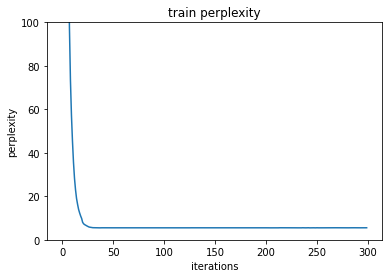

In [48]:
#device = torch.device("cpu")
VOCAB_SIZE = len(encTool.i2w)
learning_rate = 20.0
#モデル生成
print('Build model...')
model = RNNLM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)
#optimizer = optim.Adam(model.parameters(),
#                       lr=0.001,
#                       betas=(0.9, 0.999), amsgrad=True)
hist = {'train_loss': [], 'ppl':[]}

def train_step(x, t, hidden1, hidden2):
    optimizer.zero_grad() #勾配が累積されるのを防ぐ
    preds, hidden1, hidden2 = model(x, hidden1, hidden2)
    # 損失計算
    loss = criterion(preds.view(-1, VOCAB_SIZE), t.view(-1))
    loss.backward()
    #勾配クリッピング
    nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    optimizer.step() #パラメータ更新
    # 隠れ状態の計算グラフを消去
    hidden1 = tuple(h.detach() for h in hidden1)
    hidden2 = tuple(h.detach() for h in hidden2)

    return loss, preds

def eval_perplexity(model, iterator):
    total_loss = 0
    hidden1, hidden2 = None, None
    model.eval()
    with torch.no_grad():
      for input, target in iterator:
        output, hidden1, hidden2 = model(input, hidden1, hidden2)
        loss = F.cross_entropy(output.view(-1, VOCAB_SIZE), target.view(-1))
        total_loss += loss.item()
    
    ppl = math.exp(total_loss / len(iterator))
    return ppl

best_ppl = float('inf')
ppl_list = []
for epoch in tqdm(range(epochs)):
    model.train() #モデルを訓練モードに
    train_loss = 0.
    loss_count = 0
    hidden1, hidden2 = None, None
    for i, iters in enumerate(train_iter):
        x, t = iters
        x, t = x.to(device), t.to(device)
        optimizer.zero_grad() #勾配が累積されるのを防ぐ
        preds, hidden1, hidden2 = model(x, hidden1, hidden2)
        #  損失計算
        loss = criterion(preds.view(-1, VOCAB_SIZE), t.view(-1))
        loss.backward()
        #勾配クリッピング
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step() #パラメータ更新
        # 隠れ状態の計算グラフを消去
        hidden1 = tuple(h.detach() for h in hidden1)
        hidden2 = tuple(h.detach() for h in hidden2)
        train_loss += loss.item()
        loss_count += 1
    # perplexity
    ppl = np.exp(train_loss / loss_count)    
    ppl_list.append(ppl)
    #出力を見る
    
    # 検証データで評価
    val_ppl = eval_perplexity(model, val_iter)
    print(f'| epoch {epoch+1} : valid perplexity {val_ppl:.2f} |')
    if val_ppl < best_ppl:
      best_ppl = val_ppl
      model_name = OUTPUT_MODEL_DIR + "batch{}_bptt{}_hid{}_emb{}_epoch{}.pt".format(BATCH_SIZE, BPTT_LEN, HIDDEN_DIM, EMBEDDING_DIM, epoch)
      torch.save(model.state_dict(), model_name)
    else:
      learning_rate /= 4.0
      for group in optimizer.param_groups:
        group['lr'] = learning_rate

torch.save(model.state_dict(), OUTPUT_MODEL_DIR+"batch{}_bptt{}_hid{}_emb{}_epoch{}.pt".format(BATCH_SIZE, BPTT_LEN, HIDDEN_DIM, EMBEDDING_DIM, epoch))

#perplexity の確認
plt.plot(ppl_list)
plt.ylim((0, 100))
plt.xlabel('iterations')
plt.ylabel('perplexity')
plt.title('train perplexity')
plt.show()

chunk2midi.py 

In [49]:
def num2note_on_off(num):
  if int(num, 10) == 1:
    return "note_on"
  else:
    return "note_off"

#args = sys.argv 
resultTextList = Path(RESULT_TXT_DIR).glob('**/*.txt')
for resultTextName in resultTextList:
  print("converting : ", resultTextName)
  f = open(resultTextName, 'r')
  data = f.read()
  data_per_sound = data.split(",")
  textName = os.path.split(resultTextName)[1].replace(".txt", "")
  outputMidName = RESULT_MID_DIR + textName + ".mid"
  #type(note_on=1, note_off=0)_note_velocity_time
  mid = MidiFile()
  track = MidiTrack()
  mid.tracks.append(track)
  bpm = int(BPM)
  track.append(MetaMessage('set_tempo', tempo=mido.bpm2tempo(bpm)))
  for i_data in tqdm(data_per_sound):
    #print(i_data)
    if i_data == "":
      continue
    parts = i_data.split("_")
    if len(parts) != 4 or int(parts[0], 10) > 1:
      continue
    if parts[3] == "":
      continue
    if int(parts[2]) > 127:
      continue

    print(parts)
    track.append(Message(num2note_on_off(parts[0]), note=int(parts[1], 10), velocity=int(parts[2], 10), time=int(parts[3], 10)))

  mid.save(outputMidName)
